# Crypto Currency Time Series Project 

This notebook aims to deliver a tuned ARIMA model capable of predicting price values of some of the most famous  
crypto currencies based on the past data

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Define the API params

First define the coin to predict, actual date and a past date of n years in the past.  
Lastly define other API params such as currency and number of decimals.

In [2]:
coin = 'ethereum'

In [3]:
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'

In [4]:
years = 4

In [5]:
today = int(datetime.datetime.now().timestamp())

In [6]:
past_date = int((datetime.datetime.now() - datetime.timedelta(days=365 * years)).timestamp())

In [7]:
params = {'vs_currency': 'usd',
          'from': past_date,
          'to': today,
          'precision': 2}

In [8]:
response = requests.get(url, params=params).json()

In [9]:
df = pd.DataFrame(response["prices"], columns=["Timestamp", "Price"])
df.head()

,Timestamp,Price
0,1574380800000,161.15
1,1574467200000,149.93
2,1574553600000,151.97
3,1574640000000,140.25
4,1574726400000,146.35


# Data Cleaning 

Change the date table to a more human readable format, from Timestamp to yyyy-mm-dd

In [10]:
df['Date']= df['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

In [11]:
df['Timestamp'] = df['Date']

In [12]:
df.drop(columns=['Date'], inplace=True)

In [13]:
df.rename(columns={'Timestamp': 'Date'}, inplace=True)

In [14]:
df['Date']=pd.to_datetime(df['Date'])

In [15]:
df.head()

,Date,Price
0,2019-11-21,161.15
1,2019-11-22,149.93
2,2019-11-23,151.97
3,2019-11-24,140.25
4,2019-11-25,146.35


In [16]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

<AxesSubplot:title={'center':'ethereum trend'}, xlabel='Date', ylabel='Price'>

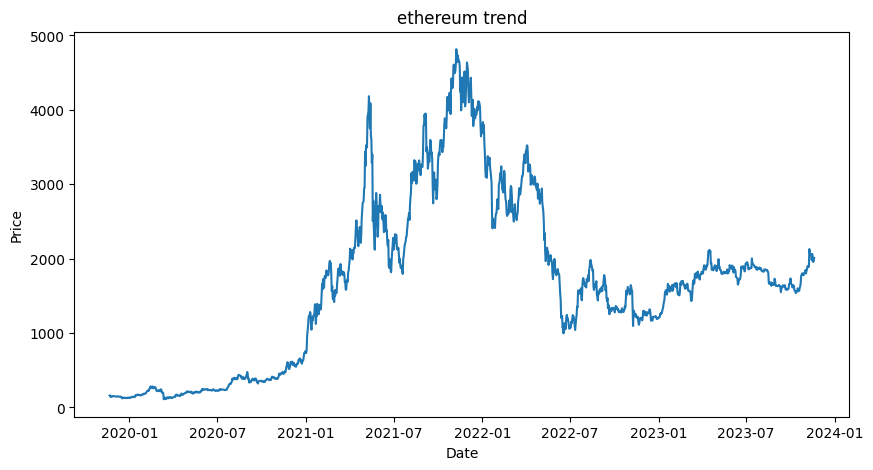

In [17]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend')
sns.lineplot(data=df, x='Date', y='Price')

# SARIMA Grid Search

In [18]:
df['log'] = np.log(df.Price)

<AxesSubplot:title={'center':'ethereum trend log data'}, xlabel='Date', ylabel='log'>

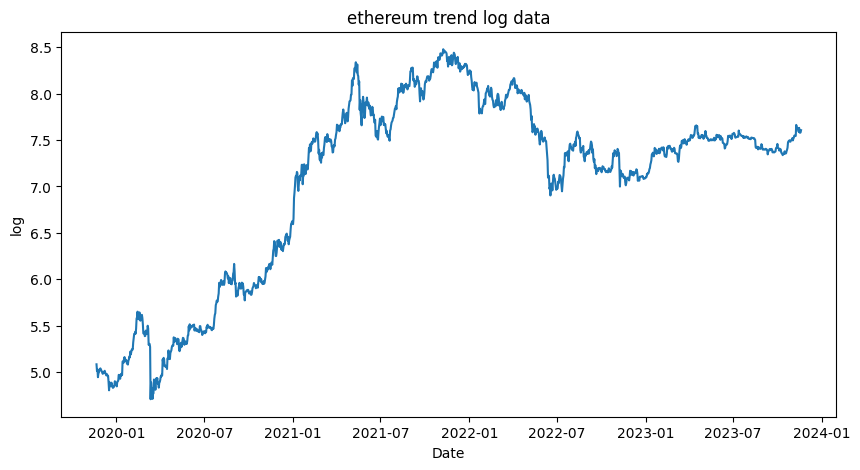

In [19]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend log data')
sns.lineplot(data=df, x='Date', y='log')

In [20]:
len(df)

1460

## Train Test Split

In [21]:
train_percentage = int(0.9*(len(df)))

In [22]:
train_percentage

1314

In [23]:
# Create train test split
train = df.log[:train_percentage]
test = df.log[train_percentage:]

## Testing Stationarity and finding seasonality

Text(0.5, 1.0, '1st Order Differencing')

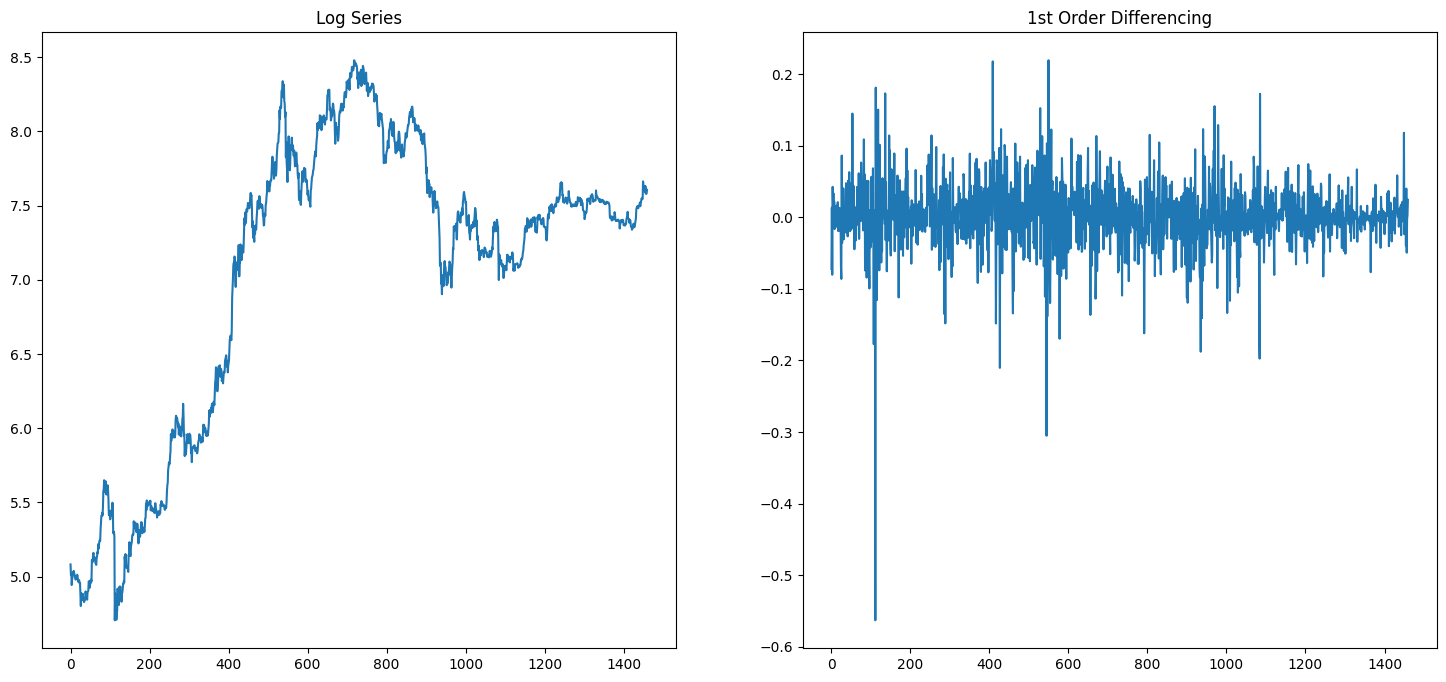

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(18,8))


# Log series
axs[0].plot(df.log); axs[0].set_title('Log Series')

# Normal differencing
axs[1].plot(df.log.diff(1)); axs[1].set_title('1st Order Differencing')


In [25]:
# P Value for trusting stationarity 
adfuller(df.log)[1]  # Original data

0.298179970474612

In [26]:
# P Value for trusting stationarity 
adfuller(df.log.diff(1).dropna())[1]  # First order diff

9.657903092771087e-21

In [27]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(train)

1

In [28]:
price_diff =df.log.diff(1).dropna()

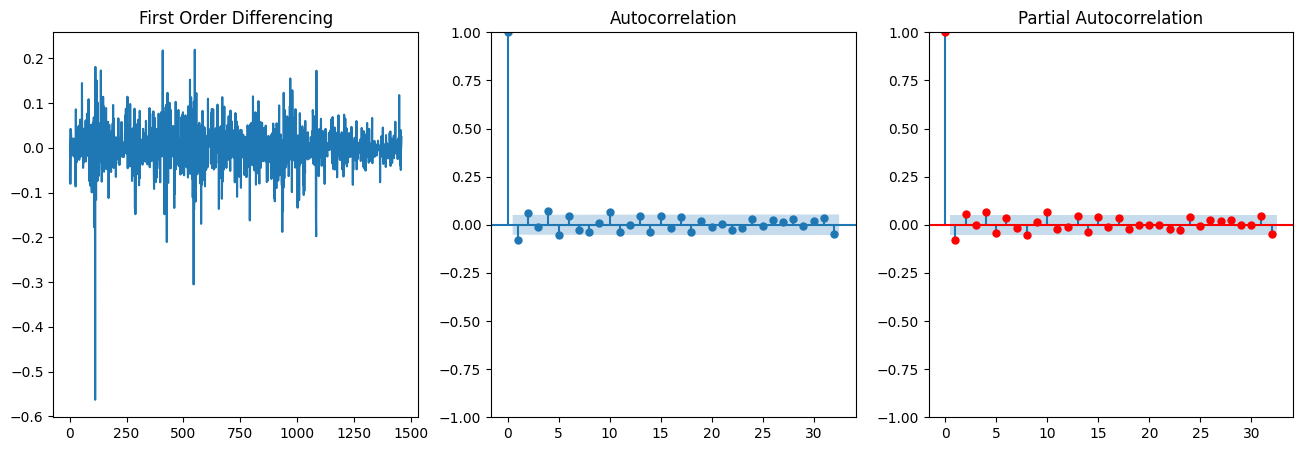

In [29]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].plot(price_diff)
axes[0].set_title('First Order Differencing')
plot_acf(price_diff, ax=axes[1]);
plot_pacf(price_diff, ax=axes[2], c='r');

In [30]:
#Grid Search
smodel = pm.auto_arima(train, seasonal = False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4216.772, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4207.857, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4213.973, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4213.122, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4207.934, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4218.464, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4215.521, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4220.464, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4214.175, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4216.085, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4220.344, Time=0.09 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.302 seconds


In [31]:
predictions_sm = smodel.predict(len(test), return_conf_int=True)

In [32]:
p, d, q = smodel.order

# Build Model and Predict

In [33]:


# 1. initialize the model
arima = ARIMA(train, order=(p, d, q))

# 2. fit the models
arima = arima.fit()

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                 1314
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2113.172
Date:                Sun, 19 Nov 2023   AIC                          -4220.344
Time:                        20:53:50   BIC                          -4204.804
Sample:                             0   HQIC                         -4214.516
                               - 1314                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7912      0.084     -9.374      0.000      -0.957      -0.626
ma.L1          0.7224      0.096      7.549      0.000       0.535       0.910
sigma2         0.0023   3.08e-05     76.011      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15359.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Statsmodels Forecast

In [34]:
# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast_stats = forecast_results.predicted_mean
confidence_stats = forecast_results.conf_int().values

/Users/leonardomichelramirez/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [35]:
confidence_stats

array([[7.43675321, 7.62643604],
       [7.39933233, 7.65852378],
       [7.37124595, 7.69082961],
       [7.34626999, 7.71246725],
       [7.32549467, 7.73588376],
       [7.30555167, 7.75373711],
       [7.28819298, 7.77274908],
       [7.27119055, 7.78844348],
       [7.25591265, 7.80475626],
       [7.24088488, 7.81896526],
       [7.22705666, 7.83344128],
       [7.21346065, 7.84652476],
       [7.20072628, 7.85966463],
       [7.18822261, 7.87184748],
       [7.17635669, 7.88396722],
       [7.16471818, 7.89540491],
       [7.15356586, 7.90671612],
       [7.14263287, 7.91752341],
       [7.13208135, 7.92817438],
       [7.12173736, 7.93843968],
       [7.11170096, 7.94853833],
       [7.10185825, 7.95833179],
       [7.09226983, 7.96795918],
       [7.08286055, 7.97733763],
       [7.07366621, 7.98655636],
       [7.06463671, 7.99556656],
       [7.0557924 , 8.00442614],
       [7.04709941, 8.01310705],
       [7.03856857, 8.02164745],
       [7.03017657, 8.03003189],
       [7.

In [36]:
lower_stats = pd.Series(confidence_stats[:,0], index=test.index)
upper_stats = pd.Series(confidence_stats[:,1], index=test.index)

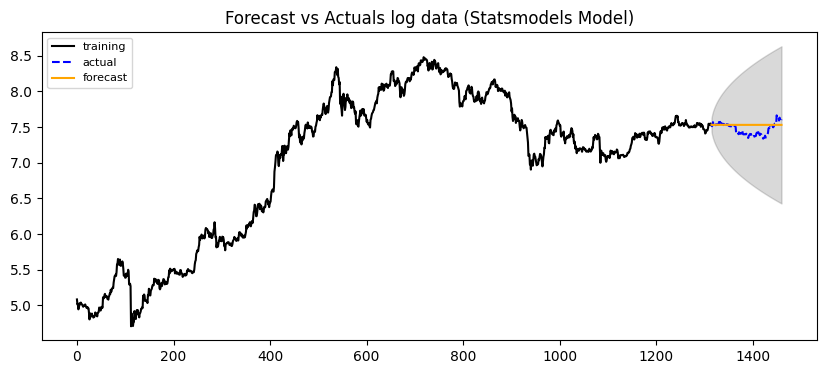

In [37]:
# Plot
plt.figure(figsize=(10,4), dpi=100)
plt.plot(train, label='training', color='black')
plt.plot(test, label='actual', color='blue', ls='--')
plt.plot(forecast_stats, label='forecast', color='orange')
plt.fill_between(lower_stats.index, lower_stats, upper_stats, color='k', alpha=.15)
plt.title('Forecast vs Actuals log data (Statsmodels Model)')
plt.legend(loc='upper left', fontsize=8);

In [38]:
# Re-compose back to initial TS

forecast_recons_stats = np.exp(forecast_stats)
train_recons_stats = np.exp(train)
test_recons_stats = np.exp(test)
lower_recons_stats = np.exp(lower_stats)
upper_recons_stats = np.exp(upper_stats)

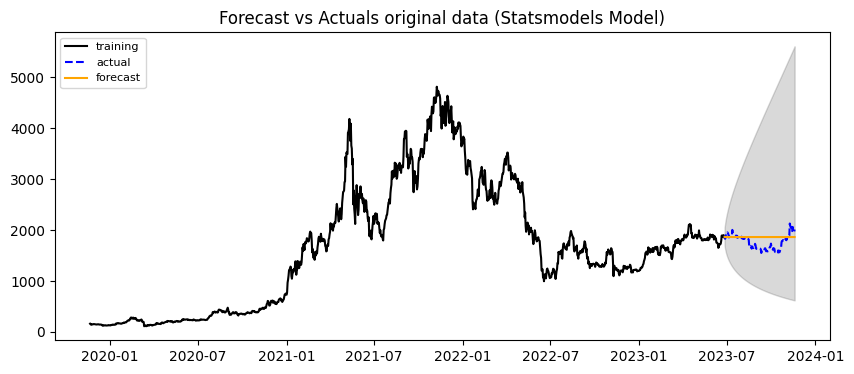

In [39]:
# Plot Original TS and forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(df.Date[:train_percentage],train_recons_stats, label='training', color='black')
plt.plot(df.Date[train_percentage:],test_recons_stats, label='actual', color='blue', ls='--')
plt.plot(df.Date[train_percentage:],forecast_recons_stats,label='forecast', color='orange')
plt.fill_between(df.Date[train_percentage:], lower_recons_stats, upper_recons_stats, color='k', alpha=.15)
plt.title('Forecast vs Actuals original data (Statsmodels Model)')
plt.legend(loc='upper left', fontsize=8);

## pmdarima Forecast

In [40]:
forecast_pm = predictions_sm[0]

In [41]:
lower_pm = pd.Series(predictions_sm[1][:,0], index=test.index)
upper_pm = pd.Series(predictions_sm[1][:,1], index=test.index)

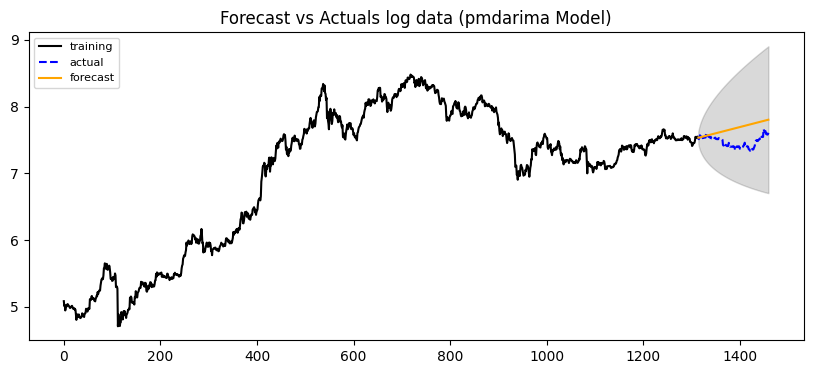

In [42]:
# Plot
plt.figure(figsize=(10,4), dpi=100)
plt.plot(train, label='training', color='black')
plt.plot(test, label='actual', color='blue', ls='--')
plt.plot(forecast_pm, label='forecast', color='orange')
plt.fill_between(lower_pm.index, lower_pm, upper_pm, color='k', alpha=.15)
plt.title('Forecast vs Actuals log data (pmdarima Model)')
plt.legend(loc='upper left', fontsize=8);

In [43]:
# Re-compose back to initial TS

forecast_recons_pm = np.exp(forecast_pm)
train_recons_pm = np.exp(train)
test_recons_pm = np.exp(test)
lower_recons_pm = np.exp(lower_pm)
upper_recons_pm = np.exp(upper_pm)

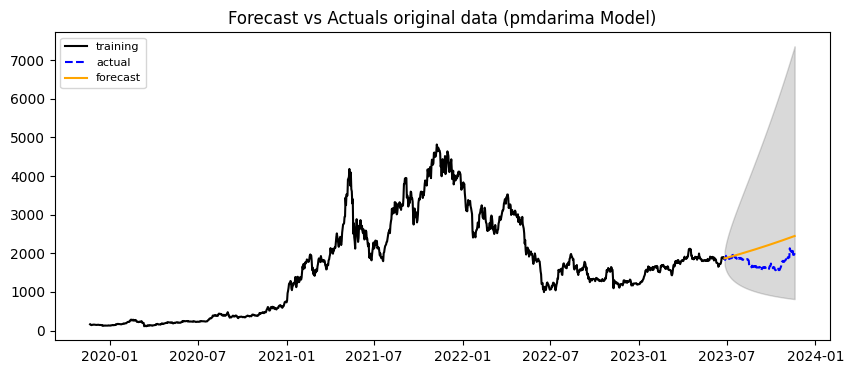

In [44]:
# Plot Original TS and forecast
plt.figure(figsize=(10,4), dpi=100)
plt.plot(df.Date[:train_percentage],train_recons_pm, label='training', color='black')
plt.plot(df.Date[train_percentage:],test_recons_pm, label='actual', color='blue', ls='--')
plt.plot(df.Date[train_percentage:],forecast_recons_pm,label='forecast', color='orange')
plt.fill_between(df.Date[train_percentage:], lower_recons_pm, upper_recons_pm, color='k', alpha=.15)
plt.title('Forecast vs Actuals original data (pmdarima Model)')
plt.legend(loc='upper left', fontsize=8);

# Evaluate Models with MAPE

## Stats Model Evaluation

In [45]:
mape_stats = mean_absolute_percentage_error(test_recons_stats,forecast_recons_stats)
mape_stats

0.08198177190830758

## pmdarima Model Evaluation

In [46]:
mape_stats = mean_absolute_percentage_error(test_recons_pm,forecast_recons_pm)
mape_stats

0.22558016764279398

In [47]:
forecast_recons_pm

1314    1869.732157
1315    1868.110507
1316    1875.645394
1317    1875.945508
1318    1881.983508
           ...     
1455    2428.701925
1456    2433.237819
1457    2437.782184
1458    2442.335036
1459    2446.896391
Length: 146, dtype: float64

In [48]:
forecast_recons_stats

1314    1866.078828
1315    1861.109426
1316    1865.040000
1317    1861.929541
1318    1864.390031
           ...     
1455    1863.302814
1456    1863.302814
1457    1863.302814
1458    1863.302814
1459    1863.302814
Name: predicted_mean, Length: 146, dtype: float64

# Final Observations

Both Models make the exact same forecast for ether crypto currency, however it seems to be a kind of constant forecast with not much peaks going up or even lower values.